In [1]:
using BenchmarkTools, SpecialFunctions
using LinearAlgebra, Statistics
using Parameters
using Plots
using Optim #https://github.com/JuliaNLSolvers/Optim.jl
using Random, Distributions
gr(fmt=:png); # setting for easier display in jupyter notebooks
using ThreadsX, Folds # these are multithreading tools
using QuantEcon
using SparseArrays
using BasisMatrices
using NLsolve
using ForwardDiff

In [50]:
function consumption(R, a, ap, w)
        # constructs consumption via the hh budget constraint
        # .- boadcasting is used to turn vectors (a,ap) into a grid
        # over c (na by na)
    
        c = R*a .- ap .+ w
    
    return c
    
end

##########################################################################
##########################################################################

function utility(c, γ)
    # maps consumption into utility with the CRRA specification
    # log it γ is close to one
    
    if abs(γ - 1.0) < 1e-10
        
        (c < 1e-5 ? -1e10 : log(c)) 

    else
        (c < 1e-5 ? -1e10 : c^( 1.0 - γ) / (1.0 - γ)) 
    end

end

##########################################################################
##########################################################################

function make_utility(model_params)
    # just a wraper that takes model paramters and constructs consumption
    # then utility which will be na by na by nshocks size
    # this is then used in the value function routine
        
    @unpack Na, Nshocks, γ, R, mc, agrid = model_params
    
    utility_grid = Array{Float64}(undef, Na, Na, Nshocks)
    
    a =  reshape(agrid, Na, 1)
    
    a_prime = reshape(agrid, 1, Na)
    
    for xxx = 1:Nshocks
        
        c = consumption(R, a, a_prime, exp.(mc.state_values[xxx]))
        
        utility_grid[:, :, xxx] = utility.(c, γ)
    
    end
    
    return utility_grid
    
end

##########################################################################
##########################################################################

#function compute_EV(v::Array{T}, mc_probs::Array{T}) where T<:AbstractFloat
function compute_EV(v, mc_probs)
    # given value functions (v) for a and shock, construct expected value
    # given the transition probabiltes from the markov chain...
    
    # so mc_probs should be a 1 by Nshock row vector 
    # then v should be Nassset state, Nshock state matrix
    # we want to integrate this so transpose, so for a given
    # asset state integrate accross different shock outcomes
    
    return  (mc_probs' * v' )

end

##########################################################################
##########################################################################

#function bellman_operator(v::Array{T},u::Array{T}, mc::Array{T}, β::T) where T<:AbstractFloat
function bellman_operator(v,u, mc, β)     
    
    # this is the value function /bellman operatore that takes a v then
    # returns a TV where the TV satisfies the recursive relationship that
    # TV = max u + βEV
    #
    # Note, and per quantecon advice, this is seperate from **how** we sovle
    # for the situation where TV = V. This just says, you give me a V, I give 
    # you a TV.         
    
        Na = size(u)[1]
        Nshocks = size(u)[3]
    
        Tv = similar(v)
    
        for xxx in 1:Nshocks
                    
            βEV = compute_EV(β*v, mc[xxx,:])
            
            maximum!(view(Tv,:,xxx), u[:, :, xxx] .+ βEV )
            
            #this is fastest and writes on TV directly
            # lower number of allocations too
            # the view command is what allows the direct writing on 
            # a slice of the array, without it, nodice

        end
    
    return Tv
    
end


##########################################################################
##########################################################################

#function bellman_operator(v::Array{T},u::Array{T}, mc::Array{T}, 
#        β::T, policy::Matrix{CartesianIndex{2}}) where T<:AbstractFloat
function bellman_operator(v,u, mc, β, policy::Matrix{CartesianIndex{2}})     

    # here I'm exploiting mulitple dispatch. If I pass a matrix of cartesian
    # index's, I'll get back the policy function
    
    # this is the value function /bellman operatore that takes a v then
    # returns a TV where the TV satisfies the recursive relationship that
    # TV = max u + βEV
    #
    # Note, and per quantecon advice, this is seperate from **how** we sovle
    # for the situation where TV = V. This just says, you give me a V, I give 
    # you a TV. 
    
        Na = size(u)[1]
        Nshocks = size(u)[3]
    
        Tv = similar(v)
    
        for xxx in 1:Nshocks
                    
            βEV = compute_EV(β*v, mc[xxx,:])
            
            Tv[:, xxx], policy[:, xxx] = findmax(u[:, :, xxx] .+ βEV , dims = 2)
            
            #this is fastest and writes on TV directly
            # lower number of allocations too
            # the view command is what allows the direct writing on 
            # a slice of the array, without it, nodice

        end
    
    return Tv, policy
    
end

##########################################################################
##########################################################################

function value_function_itteration(model_params ; tol = 10^-3)
    # this is the boiler plate vfi routine (1) make grid (2) itterate on 
    # bellman operator untill convergence. Policy 
    # functions are then outputed as cartesian index
    #
    # as Fast/ ~faster than Matlab (but nothing is multithreaded here)
    # fastest is using nlsove fixed point to find situation where
    # v = bellman_operator(v)
    
    @unpack Na, Nshocks, Niter, β, mc = model_params
    
    u = make_utility(model_params)

    Tv = zeros(Na, Nshocks)
    
    v = similar(Tv)

    for iter in 1:Niter
        
        Tv = bellman_operator(Tv,u,mc.p,β)
        #there is some advantage of having it
        # explicity, not always recreating the Tv 
        # array in the function
    
        test_tol = maximum(abs, Tv - v)
        
        if test_tol < tol
            
            #println("value function converged")
            #println(iter)
            #println(test_tol)
                        
            break
        end
        
        v = copy(Tv)
        #copy!(v, Tv)

    end
    
    policy = Array{CartesianIndex{2}}(undef, size(Tv))
            
    Tv, policy = bellman_operator(Tv,u,mc.p,β,policy)
    
    return Tv, policy
    
end


##########################################################################
##########################################################################


function make_transition_prob(model_params, asset_indx::Matrix{CartesianIndex{2}})
    # takes the policy function and then creates the transition matrix which is setup 
    # where each row is shock, asset combination and describes prob of moving to new 
    # shock asset combination in columns 
    # TODO: explore sparse arrays
      
    @unpack Na, Nshocks, mc = model_params

    statesize = Int(Na*Nshocks)
    
    transition_prob = Array{Float64}(undef, statesize, statesize)
    
    foo = Array{Float64}(undef, 1, Na) 

    for ast = 1:Na
        
        ast_counter = Int((ast - 1)*Nshocks)
            
        for shk = 1:Nshocks
            
            fill!(foo, 0.0)
    
            foo[asset_indx[ast, shk][2]] = 1.0
    
            transition_prob[shk + ast_counter, :] = BasisMatrices.row_kron(foo, mc.p[shk,:]' )
            
            # this part on the row still confuses me a bit...need to explain better.
            
            #println(shk + ast_counter)
            
        end
        
    end
    
    return transition_prob
    
end

##########################################################################
##########################################################################


function fixed_dist(L , Q)
    # Takes the transition matrix Q and given a distribution L, advances it
    # where Lnew = Q'*L
    # usefull to construct stationary where L = Q'*L
    
    return transpose(Q) * L
    
end

##########################################################################
##########################################################################

function stationary_dist(Q)
    # this is faster than the quant econ canned routine
    # from lyon-waugh implementation. Not as fast as using
    # NLsolve fixedpoint routine below.
    
    # Takes the transition matrix above then we know a stationary distribution
    # must satisfy the fixed point relationsip L = Q'*L  
    
    L = zeros(size(Q)[1], 1)
    
    L[1] = 1.0
    
    max_it = 5000
    
    Lnew = similar(L)
    
    for xxx in 1:max_it
        
        Lnew = transpose(Q) * L
        #this ordering is also better in julia
        # than my matlab implementation of Q*L (1, na*nshock)
                
        err = maximum(abs, L - Lnew)
        
        copy!(L, Lnew)
        # this surprisingly makes a big difference
        # but in the vfi it causes a slowdown?
        
        err < 1e-10 && break
        
    end
    
    return L
end

stationary_dist (generic function with 2 methods)

These are model parameters from my [Hugget matlab economy](https://github.com/mwaugh0328/Hugget-Economy) which was verified against the LS presentation.

In [3]:
model_params = @with_kw (
    β= 0.96,
    R = 1.0292,
    γ = 3.0,
    amin = -3.0,
    amax = 16.0,
    Na=100,
    agrid = range(amin,amax,length=Na),
    Nshocks = 7,
    ρ = 0.20,
    σ = 0.3919,
    mc= rouwenhorst(Nshocks, ρ, σ),
    Niter = 500,
    )

##NamedTuple_kw#260 (generic function with 2 methods)

### Basic VFI

This solve the stationary eq, for a given R, using the value funciton itteration approach and then the itterative approach to solve for the stationary distribution. It then plots the histogram of asset holdings across the asset space

  0.252031 seconds (14.52 k allocations: 256.402 MiB, 31.96% gc time)
vfi done
  0.010569 seconds (2.00 k allocations: 15.534 MiB)
  0.109275 seconds (896 allocations: 6.945 MiB)


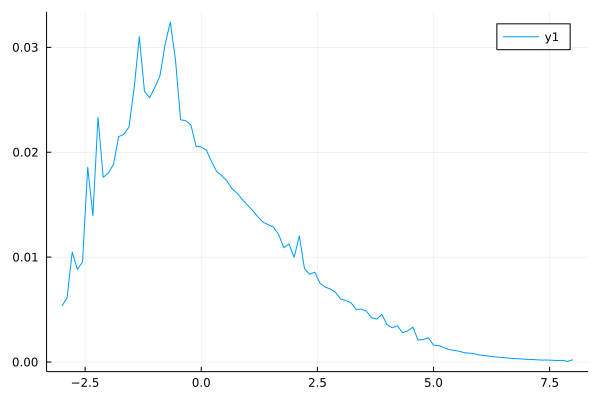

In [67]:
test = model_params(σ = 0.3919, Nshocks = 10, Na = 100, amin = -3.0, amax = 8)

@time vfout, pout = value_function_itteration(test ; tol = 10^-3);

println("vfi done")

@time tprob = make_transition_prob(test, pout);

@time  st = stationary_dist(tprob);

st = reshape(st,test.Nshocks,test.Na)'

plot(test.agrid, sum(st, dims = 2))

## Using a Solver to find VF and Stationary Distribution

This approach solves for the fixed points using NLsolve's fixedpoint routine. It's fast, appears to be very robust. Note as well that in the value function part (or stationary distribution), I did not have to reshape the input V. The NLsolve understood the issue an presumable does all what it needs to in the back end.

With a 200 asset grid, 20 shocks, the VFI is about 5X faster, stationary is 3X

  0.055545 seconds (6.65 k allocations: 61.557 MiB, 24.97% compilation time)
28
  0.015185 seconds (2.00 k allocations: 15.534 MiB)
  0.069205 seconds (4.45 k allocations: 18.525 MiB, 17.20% compilation time)
121


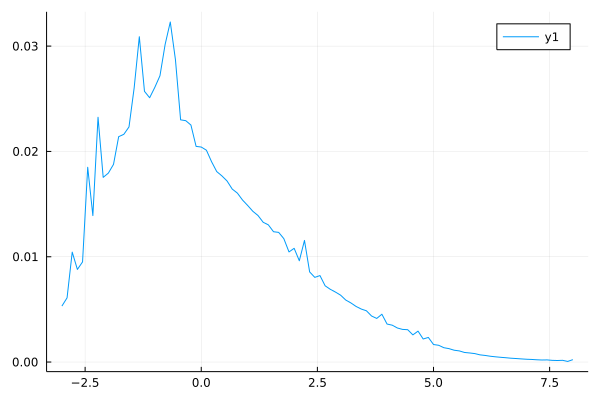

In [68]:
# make utility grid

u = make_utility(test)

# define the inline function on the bellman operator. 
# so the input is v (other stuff is fixed)

T(v) = bellman_operator(v,u,test.mc.p,test.β)

initialvalue = -ones(test.Na, test.Nshocks) / (1- test.β)

@time vfisol = fixedpoint(T, initialvalue, ftol = 1e-3, method = :anderson)

# this then implements the solution to the fixed point using
# NLsolve here: https://github.com/JuliaNLSolvers/NLsolve.jl
# mcall example here: 
# https://julia.quantecon.org/getting_started_julia/julia_by_example.html#example-variations-on-fixed-points


println(vfisol.f_calls)
#this approach works very good.

policy = Array{CartesianIndex{2}}(undef, size(vfisol.zero))
            
vf, policy = bellman_operator(vfisol.zero, u, test.mc.p, test.β, policy);
# use multiple dispacth to grab the policy function

@time Q = make_transition_prob(test, policy);

##########################################################

g(L) = fixed_dist(L, Q)

# same deal as above, inline function where the 
# distribution must L = Q'L

initialvalue = zeros(size(Q)[1], 1)
    
initialvalue[1] = 1.0 

@time stsol = fixedpoint(g, initialvalue, ftol = 1e-10, method = :anderson)
# same deal

println(stsol.f_calls)

st = reshape(stsol.zero,test.Nshocks,test.Na)';

plot(test.agrid, sum(st, dims = 2))

### Autodiff example

This uses newton method + autodifferntiaion (note a key issue getting this to run was that the types are completly generic). It works, but is far from as fast as the anderson acceleration method. With the 20 shocks, 200 grid, it's like 100+ seconds vs. a quarter of a second with anderson. 

  4.556149 seconds (149.56 k allocations: 7.932 GiB, 10.37% gc time, 2.25% compilation time)
8
  0.008054 seconds (2.00 k allocations: 15.534 MiB)
  0.049745 seconds (4.45 k allocations: 18.525 MiB, 18.05% compilation time)
121


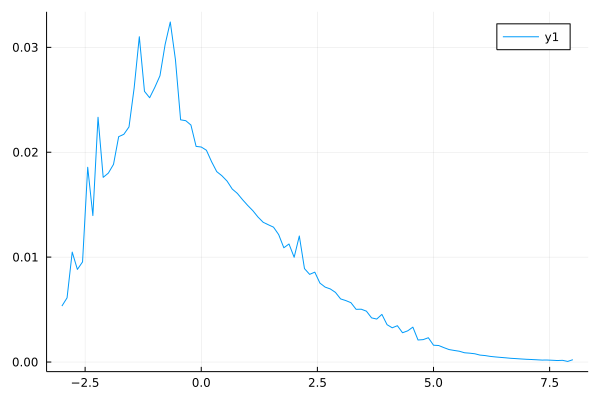

In [69]:
# make utility grid

u = make_utility(test)

# define the inline function on the bellman operator. 
# so the input is v (other stuff is fixed)

T(v) = bellman_operator(v,u,test.mc.p,test.β)

initialvalue = -ones(test.Na, test.Nshocks) / (1- test.β)

@time vfisol = fixedpoint(T, initialvalue, ftol = 1e-3, method = :newton, autodiff = :forward)

# this then implements the solution to the fixed point using
# NLsolve here: https://github.com/JuliaNLSolvers/NLsolve.jl
# mcall example here: 
# https://julia.quantecon.org/getting_started_julia/julia_by_example.html#example-variations-on-fixed-points


println(vfisol.f_calls)
#this approach works very good.

policy = Array{CartesianIndex{2}}(undef, size(vfisol.zero))
            
vf, policy = bellman_operator(vfisol.zero, u, test.mc.p, test.β, policy);
# use multiple dispacth to grab the policy function

@time Q = make_transition_prob(test, policy);

##########################################################

g(L) = fixed_dist(L, Q)

# same deal as above, inline function where the 
# distribution must L = Q'L

initialvalue = zeros(size(Q)[1], 1)
    
initialvalue[1] = 1.0 

@time stsol = fixedpoint(g, initialvalue, ftol = 1e-10, method = :anderson)
# same deal

println(stsol.f_calls)

st = reshape(stsol.zero,test.Nshocks,test.Na)';

plot(test.agrid, sum(st, dims = 2))

This is the example without autodiff...about 3X slower

 16.462915 seconds (1.93 M allocations: 28.783 GiB, 15.29% gc time, 0.86% compilation time)
9
  0.009899 seconds (2.00 k allocations: 15.534 MiB)
  0.054665 seconds (4.45 k allocations: 18.525 MiB, 16.48% compilation time)
121


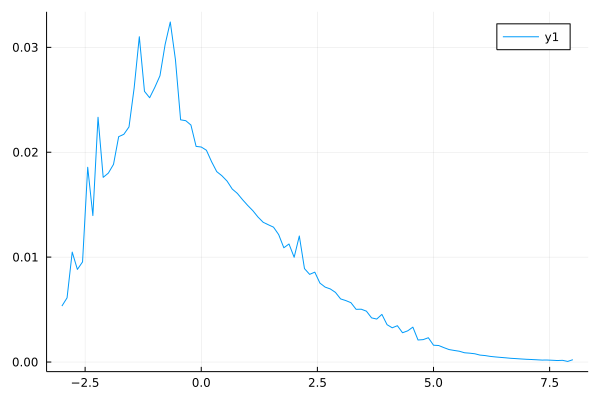

In [70]:
# make utility grid

u = make_utility(test)

# define the inline function on the bellman operator. 
# so the input is v (other stuff is fixed)

T(v) = bellman_operator(v,u,test.mc.p,test.β)

initialvalue = -ones(test.Na, test.Nshocks) / (1- test.β)

@time vfisol = fixedpoint(T, initialvalue, ftol = 1e-3, method = :newton)

# this then implements the solution to the fixed point using
# NLsolve here: https://github.com/JuliaNLSolvers/NLsolve.jl
# mcall example here: 
# https://julia.quantecon.org/getting_started_julia/julia_by_example.html#example-variations-on-fixed-points


println(vfisol.f_calls)
#this approach works very good.

policy = Array{CartesianIndex{2}}(undef, size(vfisol.zero))
            
vf, policy = bellman_operator(vfisol.zero, u, test.mc.p, test.β, policy);
# use multiple dispacth to grab the policy function

@time Q = make_transition_prob(test, policy);

##########################################################

g(L) = fixed_dist(L, Q)

# same deal as above, inline function where the 
# distribution must L = Q'L

initialvalue = zeros(size(Q)[1], 1)
    
initialvalue[1] = 1.0 

@time stsol = fixedpoint(g, initialvalue, ftol = 1e-10, method = :anderson)
# same deal

println(stsol.f_calls)

st = reshape(stsol.zero,test.Nshocks,test.Na)';

plot(test.agrid, sum(st, dims = 2))